# Clustering with hawkes processes

In [16]:
import pandas as pd

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Viz

In [17]:
df = pd.read_csv('GAZPRU.csv', parse_dates=['TradeDateTime'], index_col='TradeDateTime')

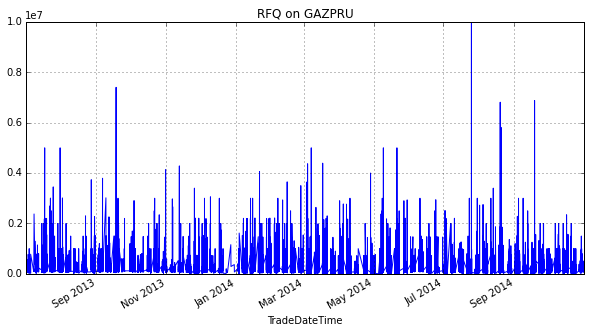

In [18]:
df['NotionalEUR'].plot(figsize=(10,5), title = 'RFQ on GAZPRU')

## Expectation-Maximization

In [19]:
from hawkes.utils import GetTimeSeriesFromCSV


time, marks = GetTimeSeriesFromCSV('GAZPRU.csv', nb_points=1000)

In [20]:
from hawkes.hawkes import ExpectationMaximization, Q

In [21]:
def inspect(verbose=False):
    it = [0]
    QQ = []
    def inspectclosed(mu, a, b, t, p, dt, T, S0, S1, S2):
        it[0] += 1
        q = Q(mu, a, b, t, p, dt)
        QQ.append(q)
        if it[0] == 1 or it[0] % 10 == 0:
            print ("iter = %s: (mu, a, b) = (%.2f, %.2f, %.2f)" % (it[0], mu, a, b)).ljust(35),
            print "Q = %s" % q
    inspectclosed.QQ = QQ
    return inspectclosed
        
inspector = inspect(verbose=False)
mu, a, b, p = ExpectationMaximization(time, niter=100, callback=inspector)

iter = 1: (mu, a, b) = (8.48, 3.87, 2.68) Q = -215.301534074
iter = 10: (mu, a, b) = (114.34, 11.86, 12.48) Q = 1188.8538585
iter = 20: (mu, a, b) = (195.09, 22.87, 27.41) Q = 2375.21505164
iter = 30: (mu, a, b) = (157.94, 133.62, 155.92) Q = 3856.40381798
iter = 40: (mu, a, b) = (138.27, 1577.46, 1821.36) Q = 6185.92419436
iter = 50: (mu, a, b) = (189.00, 2508.88, 3082.31) Q = 7009.2557988
iter = 60: (mu, a, b) = (193.44, 2567.38, 3171.75) Q = 7064.45889415
iter = 70: (mu, a, b) = (193.72, 2570.99, 3177.34) Q = 7067.91037749
iter = 80: (mu, a, b) = (193.74, 2571.22, 3177.69) Q = 7068.1257027
iter = 90: (mu, a, b) = (193.74, 2571.23, 3177.71) Q = 7068.1391348
iter = 100: (mu, a, b) = (193.74, 2571.23, 3177.71) Q = 7068.13997269


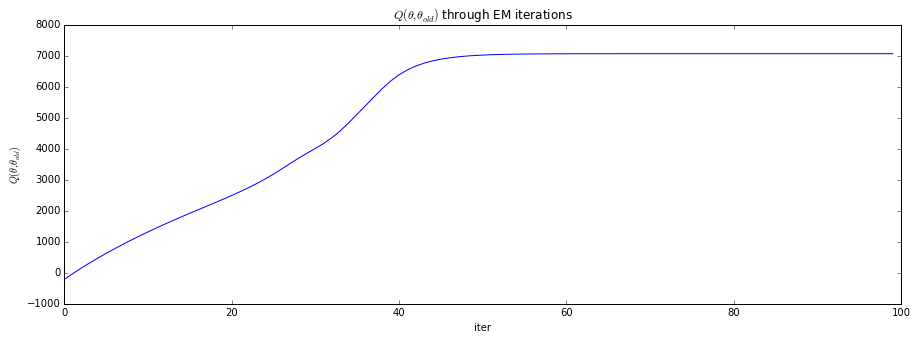

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(inspector.QQ)
plt.title(r"$Q(\theta, \theta_{old})$ through EM iterations")
plt.xlabel(r"iter")
plt.ylabel(r"$Q(\theta, \theta_{old})$")
plt.show()

In [23]:
#plt.figure(figsize=(8, 8))
#plt.imshow(p[:200, :200])
#plt.title(r"$p$ matrix of parenthood probabilities")
#plt.show()

## Get leaders

In [24]:
from hawkes.utils import GetInfluenceMatrix, InfluenceMatrixToGDF

In [25]:
customer_ids = marks["Customer"].values
g, unique_ids = GetInfluenceMatrix(p, customer_ids)

In [26]:
#plt.figure(figsize=(8, 8))
#plt.title(r"Influence matrix")
#plt.imshow(g)

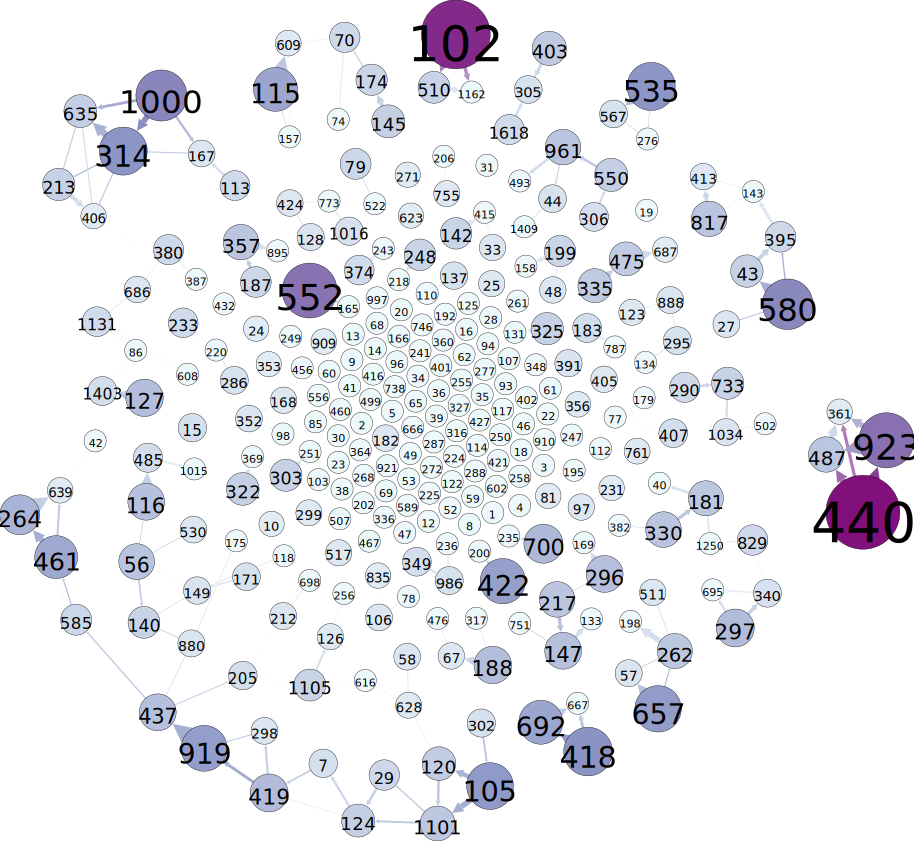

In [27]:
from IPython.display import SVG 
InfluenceMatrixToGDF(g, unique_ids, filename="influence.gdf")

# `influence.svg` was created from `influence.gdf` using Gephi (http://gephi.github.io)
SVG(filename='influence.svg') 

In [28]:
from hawkes.utils import GetLeadersFollowers

dict_leaders_followers = GetLeadersFollowers(p)
jump_ind = 99
leader = dict_leaders_followers[jump_ind]["leader"]
followers = dict_leaders_followers[jump_ind]["followers"]
print('Example: jump number {} has {} for leader; and {} for followers'.format(jump_ind, leader, followers))

Example: jump number 99 has [98] for leader; and [100] for followers


In [29]:
nb_leaders = 0
nb_jumps = 0
for key, val in dict_leaders_followers.items():
    nb_jumps +=1
    nb_followers = len(val["followers"])
    if nb_followers > 1:
        print('Jump {} has {} for followers'.format(key, val["followers"]))
    if key == val["leader"][0]:
        #print('{} is a leader'.format(key)) 
        nb_leaders +=1
print('there are {} leaders among the {} jumps'.format(nb_leaders, nb_jumps))

Jump 184 has [185, 186, 187, 188] for followers
Jump 188 has [189, 190, 191] for followers
Jump 238 has [239, 240] for followers
Jump 273 has [274, 275] for followers
Jump 277 has [278, 279, 280] for followers
Jump 310 has [311, 312, 313] for followers
Jump 348 has [349, 350] for followers
Jump 350 has [351, 352, 353, 354] for followers
Jump 370 has [371, 372, 373, 374, 375, 376] for followers
Jump 376 has [377, 378, 379, 380, 381, 382, 383, 384] for followers
Jump 401 has [402, 403, 404] for followers
Jump 404 has [405, 406, 407, 408, 409] for followers
Jump 438 has [439, 440, 441, 442, 443] for followers
Jump 457 has [458, 459, 460, 461, 462, 463, 464, 465] for followers
Jump 482 has [483, 484] for followers
Jump 566 has [567, 568] for followers
Jump 608 has [609, 610] for followers
Jump 695 has [696, 697] for followers
Jump 706 has [707, 708, 709] for followers
Jump 870 has [871, 872] for followers
Jump 899 has [900, 901, 902] for followers
there are 151 leaders among the 1000 jumps

## Create GAZPRU.csv

In [ ]:
import pandas as pd
#filename_path = '/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv'
filename_path = '/Users/lecueguillaume/Documents/bnpp/bnpp_donnees/ETSAnonymousPricesFull.csv'
df = pd.read_csv(filename_path, parse_dates=['TradeDateTime'], index_col='TradeDateTime')

In [ ]:
df2 = df[df["BuySell"] == "Buy"]
df3 = df2[df2["Ticker"] == "GAZPRU"]

In [ ]:
df3.to_csv("GAZPRU.csv")